<a href="https://colab.research.google.com/github/jmohsbeck1/jpmc_mle/blob/final_project/Copy_of_JMCopy_of_DataDazzlers_DineOracle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports

In [1]:
import os
import warnings
import itertools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

In [2]:
#Dataframe and numerical library
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', None)

#Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

!pip install descartes
!pip install geopandas
import descartes
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon

# SQLite
import sqlite3

#Machine Learning Model
#Metrics
from sklearn.metrics import mutual_info_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

#Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#Linear Model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

#Ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Others
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

#Hyper parameter
from sklearn import neighbors, datasets, model_selection

#json conversion
import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Import

In [3]:
#STEP 1: Import large dataset using opendatasets
if not os.path.exists('yelp-dataset'):
  print("Loading Keys")
  kaggle_key = 'ravikiranbutti'
  kaggle_value = '117268fa41345f39e5baeda66733a0c7'
  os.environ['KAGGLE_USERNAME'] = kaggle_key
  os.environ['KAGGLE_KEY'] = kaggle_value
  !mkdir -p /root/.kaggle
  with open('/root/.kaggle/kaggle.json', 'w') as kaggle_file:
    kaggle_file.write('{"username":"' + kaggle_key + '","key":"' + kaggle_value + '"}')

  print("Loading Data")
  !pip install kaggle
  !kaggle datasets download yelp-dataset/yelp-dataset
  !unzip yelp-dataset.zip -d 'yelp-dataset'
  !rm yelp-dataset.zip

In [4]:
#STEP 2: Load Business using chunk processing
business_chunks = pd.read_json("yelp-dataset/yelp_academic_dataset_business.json", lines=True, chunksize=10000)
business = pd.concat(business_chunks) 

In [5]:
# copy business dataframe for later use
df_business = business.copy(deep=True)

In [6]:
df_business.shape

(150346, 14)

In [7]:
#Print information
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [8]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


To convert/expand attribute column into multiple columns, convert first into a separate dataframe. Next insert columns from this dataframe to the initial dataframe.

In [9]:
# To print whole string, set limit 
pd.options.display.max_colwidth = 1000
print(f'{business.head(10).attributes}')


0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           {'ByAppointmentOnly': 'True'}
1                                                                                                                                                                                                                                                                                                                             

In [10]:
# Test with one row
#df_attribute = pd.DataFrame.from_dict(business.head(1).attributes)
#df_attribute

In [11]:
#import json - added upfront



In [12]:
attribute_json_str = business['attributes']
attribute_json_str


0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        {'ByAppointmentOnly': 'True'}
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               {

In [16]:
type(attribute_json_str)

pandas.core.series.Series

In [13]:
#For nested columns, first normalize the data
df_attributes = pd.DataFrame.from_dict(pd.json_normalize(attribute_json_str), orient='columns')


In [14]:
df_attributes.sample(10)

,ByAppointmentOnly,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,CoatCheck,RestaurantsTakeOut,RestaurantsDelivery,Caters,WiFi,BusinessParking,WheelchairAccessible,HappyHour,OutdoorSeating,HasTV,RestaurantsReservations,DogsAllowed,Alcohol,GoodForKids,RestaurantsAttire,Ambience,RestaurantsTableService,RestaurantsGoodForGroups,DriveThru,NoiseLevel,GoodForMeal,BusinessAcceptsBitcoin,Smoking,Music,GoodForDancing,AcceptsInsurance,BestNights,BYOB,Corkage,BYOBCorkage,HairSpecializesIn,Open24Hours,RestaurantsCounterService,AgesAllowed,DietaryRestrictions
125599,NaN,True,True,2,NaN,True,True,True,u'free',"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",NaN,NaN,True,False,False,False,u'none',True,u'casual',"{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': None, 'upscale': False, 'classy': False, 'casual': True}",False,True,True,'quiet',"{'dessert': None, 'latenight': False, 'lunch': True, 'dinner': None, 'brunch': None, 'breakfast': True}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104816,NaN,True,False,1,NaN,True,True,True,u'free',None,True,NaN,False,True,False,False,u'none',True,u'casual',"{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': False}",True,True,NaN,'quiet',"{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': True}",False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41650,True,True,True,3,NaN,NaN,NaN,NaN,NaN,"{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74908,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45503,False,True,NaN,NaN,NaN,NaN,NaN,NaN,u'no',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145225,True,True,NaN,1,NaN,NaN,NaN,NaN,NaN,"{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32408,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,u'free',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88722,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150209,False,True,NaN,NaN,False,False,False,False,u'no',NaN,True,False,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#Insert/append columns in initial DF
for column in df_attributes:
  business[column] = df_attributes[column]
business.head(5)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,ByAppointmentOnly,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,CoatCheck,RestaurantsTakeOut,RestaurantsDelivery,Caters,WiFi,BusinessParking,WheelchairAccessible,HappyHour,OutdoorSeating,HasTV,RestaurantsReservations,DogsAllowed,Alcohol,GoodForKids,RestaurantsAttire,Ambience,RestaurantsTableService,RestaurantsGoodForGroups,DriveThru,NoiseLevel,GoodForMeal,BusinessAcceptsBitcoin,Smoking,Music,GoodForDancing,AcceptsInsurance,BestNights,BYOB,Corkage,BYOBCorkage,HairSpecializesIn,Open24Hours,RestaurantsCounterService,AgesAllowed,DietaryRestrictions
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists",None,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', 'Wednesday': '8:0-18:30', 'Thursday': '8:0-18:30', 'Friday': '8:0-18:30', 'Saturday': '8:0-14:0'}",NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsPriceRange2': '2', 'CoatCheck': 'False', 'RestaurantsTakeOut': 'False', 'RestaurantsDelivery': 'False', 'Caters': 'False', 'WiFi': 'u'no'', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}', 'WheelchairAccessible': 'True', 'HappyHour': 'False', 'OutdoorSeating': 'False', 'HasTV': 'False', 'RestaurantsReservations': 'False', 'DogsAllowed': 'False', 'ByAppointmentOnly': 'False'}","Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', 'Wednesday': '8:0-22:0', 'Thursday': '8:0-22:0', 'Friday': '8:0-23:0', 'Saturday': '8:0-23:0', 'Sunday': '8:0-22:0'}",False,True,True,2,False,False,False,False,u'no',"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",True,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}', 'BikeParking': 'True', 'RestaurantsPriceRange2': '1', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False', 'WiFi': 'u'free'', 'Alcohol': 'u'none'', 'Caters': 'True'}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', 'Wednesday': '7:0-20:0', 'Thursday': '7:0-20:0', 'Friday': '7:0-21:0', 'Saturday': '7:0-21:0', 'Sunday': '7:0-21:0'}",False,False,True,1,NaN,True,False,True,u'free',"{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",NaN,NaN,False,NaN,NaN,NaN,u'none',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'WheelchairAccessible': 'True', 'RestaurantsTakeOut': 'True', 'BusinessParking': '{'garage': None, 

In [20]:
business.shape

(150346, 53)

In [21]:
#Need to convert BusinessParking and add as well -- the code didn't work, need to figure out

In [22]:
#STEP 3: Load Review using chunk processing and filtering unwanted colums
review = []
review_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
           }
with open("yelp-dataset/yelp_academic_dataset_review.json", "r") as f:
    review_chunks = pd.read_json(f, orient="records", lines=True, dtype=review_dtypes, chunksize=1000)
        
    for review_chunk in review_chunks:
        reduced_review_chunk = review_chunk.drop(columns=['review_id', 'useful','funny','cool', 'text','date'])
        review.append(reduced_review_chunk)
    
review = pd.concat(review, ignore_index=True)

In [23]:
#Print information
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      object 
 1   business_id  object 
 2   stars        float16
dtypes: float16(1), object(2)
memory usage: 120.0+ MB


In [24]:
#STEP 4: Load User using chunk processing and filtering unwanted colums
user = []
with open("yelp-dataset/yelp_academic_dataset_user.json", "r") as f:
    user_chunks = pd.read_json(f, orient="records", lines=True, chunksize=1000)
        
    for user_chunk in user_chunks:
        reduced_user_chunk = user_chunk.drop(columns=['name', 'useful','funny','cool', 'elite','friends'])
        user.append(reduced_user_chunk)
    
user = pd.concat(user, ignore_index=True)

In [25]:
#Print information
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   review_count        int64  
 2   yelping_since       object 
 3   fans                int64  
 4   average_stars       float64
 5   compliment_hot      int64  
 6   compliment_more     int64  
 7   compliment_profile  int64  
 8   compliment_cute     int64  
 9   compliment_list     int64  
 10  compliment_note     int64  
 11  compliment_plain    int64  
 12  compliment_cool     int64  
 13  compliment_funny    int64  
 14  compliment_writer   int64  
 15  compliment_photos   int64  
dtypes: float64(1), int64(13), object(2)
memory usage: 242.7+ MB


In [26]:
business.shape

(150346, 53)

In [27]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,ByAppointmentOnly,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,CoatCheck,RestaurantsTakeOut,RestaurantsDelivery,Caters,WiFi,BusinessParking,WheelchairAccessible,HappyHour,OutdoorSeating,HasTV,RestaurantsReservations,DogsAllowed,Alcohol,GoodForKids,RestaurantsAttire,Ambience,RestaurantsTableService,RestaurantsGoodForGroups,DriveThru,NoiseLevel,GoodForMeal,BusinessAcceptsBitcoin,Smoking,Music,GoodForDancing,AcceptsInsurance,BestNights,BYOB,Corkage,BYOBCorkage,HairSpecializesIn,Open24Hours,RestaurantsCounterService,AgesAllowed,DietaryRestrictions
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists",None,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', 'Wednesday': '8:0-18:30', 'Thursday': '8:0-18:30', 'Friday': '8:0-18:30', 'Saturday': '8:0-14:0'}",NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsPriceRange2': '2', 'CoatCheck': 'False', 'RestaurantsTakeOut': 'False', 'RestaurantsDelivery': 'False', 'Caters': 'False', 'WiFi': 'u'no'', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}', 'WheelchairAccessible': 'True', 'HappyHour': 'False', 'OutdoorSeating': 'False', 'HasTV': 'False', 'RestaurantsReservations': 'False', 'DogsAllowed': 'False', 'ByAppointmentOnly': 'False'}","Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', 'Wednesday': '8:0-22:0', 'Thursday': '8:0-22:0', 'Friday': '8:0-23:0', 'Saturday': '8:0-23:0', 'Sunday': '8:0-22:0'}",False,True,True,2,False,False,False,False,u'no',"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",True,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}', 'BikeParking': 'True', 'RestaurantsPriceRange2': '1', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False', 'WiFi': 'u'free'', 'Alcohol': 'u'none'', 'Caters': 'True'}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', 'Wednesday': '7:0-20:0', 'Thursday': '7:0-20:0', 'Friday': '7:0-21:0', 'Saturday': '7:0-21:0', 'Sunday': '7:0-21:0'}",False,False,True,1,NaN,True,False,True,u'free',"{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",NaN,NaN,False,NaN,NaN,NaN,u'none',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'WheelchairAccessible': 'True', 'RestaurantsTakeOut': 'True', 'BusinessParking': '{'garage': None, 

In [28]:
categorical_features=['business_id', 'name', 'address', 'city', 'state', 'attributes', 'categories', 'hours' 'postal_code']
numeric_features=['latitude', 'longitude', 'stars', 'review_count']
target_feature=['is_open']

Plot of points in map

In [29]:
# coverting csv to geopandas dataframe
geometry = [Point(xy) for xy in zip(business['longitude'], business['latitude'])]
gdf = GeoDataFrame(business, geometry = geometry)


<Axes: >

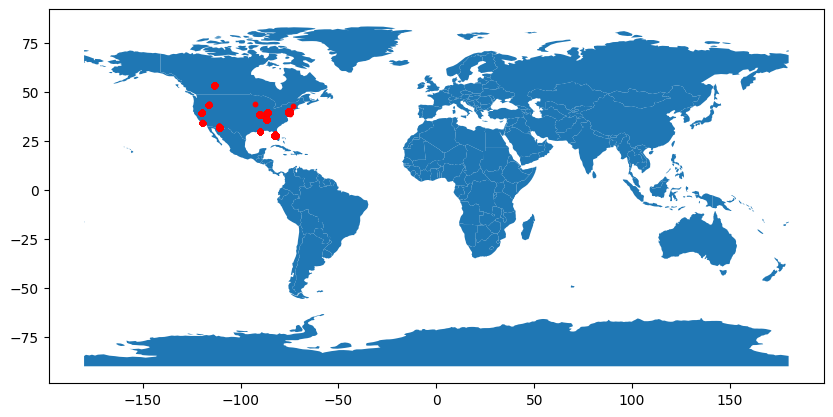

In [30]:
# plotting naturalearth_lowres map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax = world.plot(figsize = (10, 10)), color = 'red', markersize = 10)

City data

In [31]:
business['city'].unique

<bound method Series.unique of 0         Santa Barbara
1                Affton
2                Tucson
3          Philadelphia
4            Green Lane
              ...      
150341         Edmonton
150342        Nashville
150343     Indianapolis
150344     Edwardsville
150345     Apollo beach
Name: city, Length: 150346, dtype: object>

In [32]:
print(business['city'].value_counts())

Philadelphia      14569
Tucson             9250
Tampa              9050
Indianapolis       7540
Nashville          6971
                  ...  
Gentilly              1
pennsauken            1
Hamiltion             1
Newtown square        1
Apollo beach          1
Name: city, Length: 1416, dtype: int64


In [33]:
print(business['city'].value_counts(normalize=True))

Philadelphia      0.096903
Tucson            0.061525
Tampa             0.060194
Indianapolis      0.050151
Nashville         0.046366
                    ...   
Gentilly          0.000007
pennsauken        0.000007
Hamiltion         0.000007
Newtown square    0.000007
Apollo beach      0.000007
Name: city, Length: 1416, dtype: float64


<Axes: xlabel='City', ylabel='Count'>

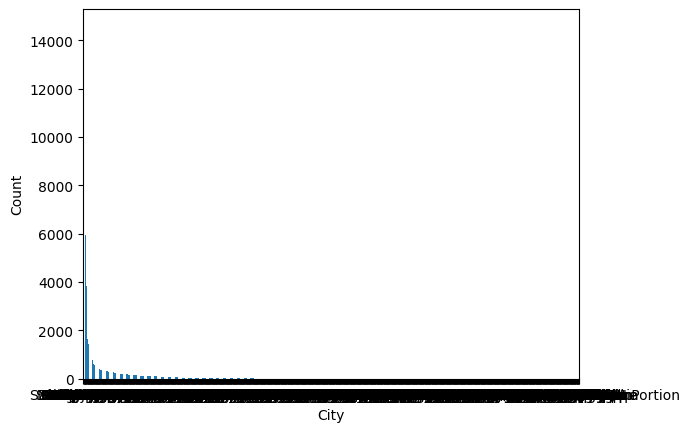

In [34]:
business['city'].value_counts().plot(kind='bar', xlabel='City', ylabel='Count', rot=0)

State data

In [35]:
print(business['state'].value_counts())

PA     34039
FL     26330
TN     12056
IN     11247
MO     10913
LA      9924
AZ      9912
NJ      8536
NV      7715
AB      5573
CA      5203
ID      4467
DE      2265
IL      2145
TX         4
CO         3
WA         2
HI         2
MA         2
NC         1
UT         1
MT         1
MI         1
SD         1
XMS        1
VI         1
VT         1
Name: state, dtype: int64


In [36]:
print(business['state'].value_counts(normalize=True))

PA     0.226404
FL     0.175129
TN     0.080188
IN     0.074807
MO     0.072586
LA     0.066008
AZ     0.065928
NJ     0.056776
NV     0.051315
AB     0.037068
CA     0.034607
ID     0.029711
DE     0.015065
IL     0.014267
TX     0.000027
CO     0.000020
WA     0.000013
HI     0.000013
MA     0.000013
NC     0.000007
UT     0.000007
MT     0.000007
MI     0.000007
SD     0.000007
XMS    0.000007
VI     0.000007
VT     0.000007
Name: state, dtype: float64


<Axes: xlabel='State', ylabel='Count'>

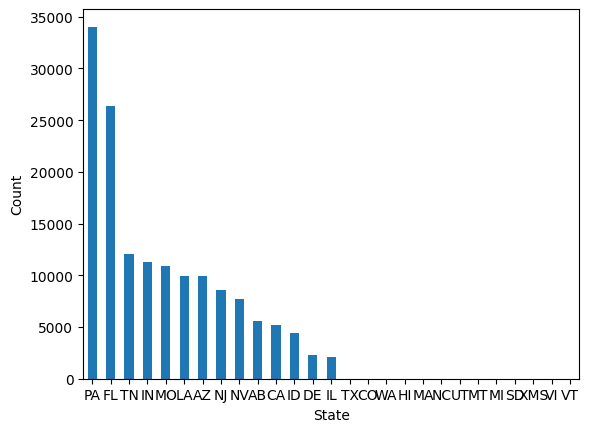

In [37]:
business['state'].value_counts().plot(kind='bar', xlabel='State', ylabel='Count', rot=0)

Categories data

In [55]:
df_categories = pd.DataFrame()
df_categories['original_categories'] = pd.DataFrame(business['categories'].tolist())

In [56]:
df_categories.head()

,original_categories
0,"Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists"
1,"Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services"
2,"Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores"
3,"Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries"
4,"Brewpubs, Breweries, Food"


In [57]:
def add_main(row):
  if row['original_categories'] is not None:   
    ls = row['original_categories'].split(",")
    ls = [x.lower().strip() for x in ls]
    if 'restaurants' in ls:
      return(str('restaurants'))
    else:   
      return(str(ls[0]))

df_categories['main_category'] = df_categories.apply(add_main, axis=1)
    

In [58]:
df_categories.head()

,original_categories,main_category
0,"Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists",doctors
1,"Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services",shipping centers
2,"Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores",department stores
3,"Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",restaurants
4,"Brewpubs, Breweries, Food",brewpubs


In [59]:
print(df_categories['main_category'])

0                            doctors
1                   shipping centers
2                  department stores
3                        restaurants
4                           brewpubs
                     ...            
150341                   nail salons
150342                          pets
150343                      shopping
150344    fitness/exercise equipment
150345                 beauty & spas
Name: main_category, Length: 150346, dtype: object


In [60]:
print(df_categories['main_category'].value_counts())

restaurants          52268
shopping              5408
beauty & spas         4375
food                  3880
home services         3783
                     ...  
qi gong                  1
hang gliding             1
dietitians               1
delicatessen             1
mortuary services        1
Name: main_category, Length: 1009, dtype: int64


In [61]:
print(df_categories['main_category'].value_counts(normalize=True))

restaurants          0.347890
shopping             0.035995
beauty & spas        0.029119
food                 0.025825
home services        0.025179
                       ...   
qi gong              0.000007
hang gliding         0.000007
dietitians           0.000007
delicatessen         0.000007
mortuary services    0.000007
Name: main_category, Length: 1009, dtype: float64


In [62]:
df_categories.shape

(150346, 2)

<Axes: xlabel='Category', ylabel='Count'>

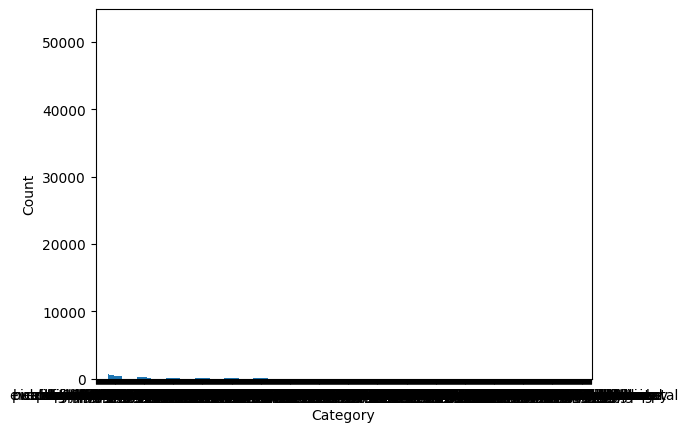

In [63]:
df_categories['main_category'].value_counts().plot(kind='bar', xlabel='Category', ylabel='Count', rot=0)

Hours data

In [64]:
df_hours = pd.DataFrame()
df_hours['original_hours'] = pd.DataFrame(business['hours'])

In [65]:
df_hours.head()

,original_hours
0,None
1,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', 'Wednesday': '8:0-18:30', 'Thursday': '8:0-18:30', 'Friday': '8:0-18:30', 'Saturday': '8:0-14:0'}"
2,"{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', 'Wednesday': '8:0-22:0', 'Thursday': '8:0-22:0', 'Friday': '8:0-23:0', 'Saturday': '8:0-23:0', 'Sunday': '8:0-22:0'}"
3,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', 'Wednesday': '7:0-20:0', 'Thursday': '7:0-20:0', 'Friday': '7:0-21:0', 'Saturday': '7:0-21:0', 'Sunday': '7:0-21:0'}"
4,"{'Wednesday': '14:0-22:0', 'Thursday': '16:0-22:0', 'Friday': '12:0-22:0', 'Saturday': '12:0-22:0', 'Sunday': '12:0-18:0'}"


In [66]:
df_hours.shape

(150346, 1)

In [67]:
def open_weekends(row):
  is_open=0
  if row['original_hours'] is not None:   
    dict1 = row['original_hours']
    dict_lower = dict((k.lower().strip(), v) for k, v in dict1.items()) 
    if 'saturday' in dict_lower.keys():
      is_open += 1
    if 'sunday' in dict_lower.keys():
      is_open += 1
  return(int(is_open))

df_hours['is_weekend'] = df_hours.apply(open_weekends, axis=1)

In [68]:
df_hours.head()

,original_hours,is_weekend
0,None,0
1,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', 'Wednesday': '8:0-18:30', 'Thursday': '8:0-18:30', 'Friday': '8:0-18:30', 'Saturday': '8:0-14:0'}",1
2,"{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', 'Wednesday': '8:0-22:0', 'Thursday': '8:0-22:0', 'Friday': '8:0-23:0', 'Saturday': '8:0-23:0', 'Sunday': '8:0-22:0'}",2
3,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', 'Wednesday': '7:0-20:0', 'Thursday': '7:0-20:0', 'Friday': '7:0-21:0', 'Saturday': '7:0-21:0', 'Sunday': '7:0-21:0'}",2
4,"{'Wednesday': '14:0-22:0', 'Thursday': '16:0-22:0', 'Friday': '12:0-22:0', 'Saturday': '12:0-22:0', 'Sunday': '12:0-18:0'}",2


In [69]:
print(df_hours['is_weekend'])

0         0
1         1
2         2
3         2
4         2
         ..
150341    2
150342    2
150343    0
150344    2
150345    1
Name: is_weekend, Length: 150346, dtype: int64


In [70]:
print(df_hours['is_weekend'].value_counts())

2    80545
0    38949
1    30852
Name: is_weekend, dtype: int64


In [71]:
print(df_hours['is_weekend'].value_counts(normalize=True))

2    0.535731
0    0.259062
1    0.205207
Name: is_weekend, dtype: float64


<Axes: xlabel='is_weekend', ylabel='Count'>

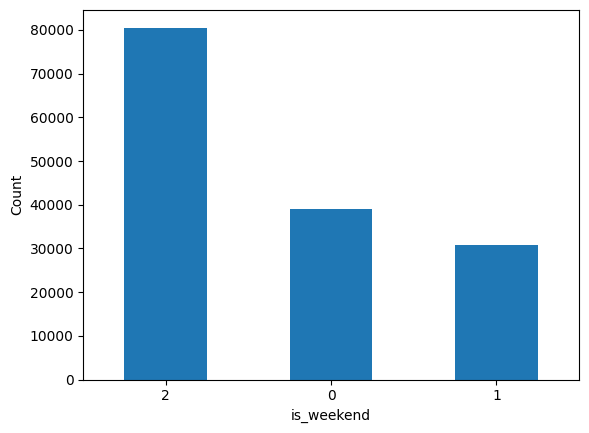

In [72]:
df_hours['is_weekend'].value_counts().plot(kind='bar', xlabel='is_weekend', ylabel='Count', rot=0)


Restaurants attributes

In [153]:
df_restaurants = pd.DataFrame()
df_restaurants['original_categories'] = pd.DataFrame(business['categories'].tolist())
df_restaurants['original_attributes'] = pd.DataFrame(business['attributes'])

In [154]:
df_restaurants.head()

,original_categories,original_attributes
0,"Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists",{'ByAppointmentOnly': 'True'}
1,"Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services",{'BusinessAcceptsCreditCards': 'True'}
2,"Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores","{'BikeParking': 'True', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsPriceRange2': '2', 'CoatCheck': 'False', 'RestaurantsTakeOut': 'False', 'RestaurantsDelivery': 'False', 'Caters': 'False', 'WiFi': 'u'no'', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}', 'WheelchairAccessible': 'True', 'HappyHour': 'False', 'OutdoorSeating': 'False', 'HasTV': 'False', 'RestaurantsReservations': 'False', 'DogsAllowed': 'False', 'ByAppointmentOnly': 'False'}"
3,"Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries","{'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}', 'BikeParking': 'True', 'RestaurantsPriceRange2': '1', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False', 'WiFi': 'u'free'', 'Alcohol': 'u'none'', 'Caters': 'True'}"
4,"Brewpubs, Breweries, Food","{'BusinessAcceptsCreditCards': 'True', 'WheelchairAccessible': 'True', 'RestaurantsTakeOut': 'True', 'BusinessParking': '{'garage': None, 'street': None, 'validated': None, 'lot': True, 'valet': False}', 'BikeParking': 'True', 'GoodForKids': 'True', 'Caters': 'False'}"


In [155]:
def load_restaurants_data(row):
  if row['original_categories'] !=None:   
    ls = row['original_categories'].split(",")
    ls = [x.lower().strip() for x in ls]
    if 'restaurants' in ls:
      return('1')
    else:
      return('0')
  else:
      return('0')

print(df_restaurants.shape)
df_restaurants['is_restaurant'] = df_restaurants.apply(load_restaurants_data, axis=1)

(150346, 2)


In [156]:
df_restaurants.head()

,original_categories,original_attributes,is_restaurant
0,"Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists",{'ByAppointmentOnly': 'True'},0
1,"Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services",{'BusinessAcceptsCreditCards': 'True'},0
2,"Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores","{'BikeParking': 'True', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsPriceRange2': '2', 'CoatCheck': 'False', 'RestaurantsTakeOut': 'False', 'RestaurantsDelivery': 'False', 'Caters': 'False', 'WiFi': 'u'no'', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}', 'WheelchairAccessible': 'True', 'HappyHour': 'False', 'OutdoorSeating': 'False', 'HasTV': 'False', 'RestaurantsReservations': 'False', 'DogsAllowed': 'False', 'ByAppointmentOnly': 'False'}",0
3,"Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries","{'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}', 'BikeParking': 'True', 'RestaurantsPriceRange2': '1', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False', 'WiFi': 'u'free'', 'Alcohol': 'u'none'', 'Caters': 'True'}",1
4,"Brewpubs, Breweries, Food","{'BusinessAcceptsCreditCards': 'True', 'WheelchairAccessible': 'True', 'RestaurantsTakeOut': 'True', 'BusinessParking': '{'garage': None, 'street': None, 'validated': None, 'lot': True, 'valet': False}', 'BikeParking': 'True', 'GoodForKids': 'True', 'Caters': 'False'}",0


In [157]:
print(df_restaurants['is_restaurant'].value_counts())

0    98078
1    52268
Name: is_restaurant, dtype: int64


In [158]:
df_restaurants.shape

(150346, 3)

In [159]:
# drop rows that not restaurants
#df_restaurants = df_restaurants.drop(df_restaurants[df_restaurants.is_restaurant == 1].index)
df_restaurants = df_restaurants[df_restaurants.is_restaurant == '1'] 

In [160]:
df_restaurants.shape

(52268, 3)

In [161]:
df_restaurants.head()

,original_categories,original_attributes,is_restaurant
3,"Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries","{'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}', 'BikeParking': 'True', 'RestaurantsPriceRange2': '1', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False', 'WiFi': 'u'free'', 'Alcohol': 'u'none'', 'Caters': 'True'}",1
5,"Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants","{'BusinessParking': 'None', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsAttire': 'u'casual'', 'OutdoorSeating': 'True', 'RestaurantsReservations': 'False', 'Caters': 'False', 'RestaurantsTakeOut': 'True', 'Alcohol': 'u'none'', 'Ambience': 'None', 'GoodForKids': 'True', 'RestaurantsPriceRange2': '1', 'ByAppointmentOnly': 'False', 'CoatCheck': 'False', 'DogsAllowed': 'False', 'RestaurantsTableService': 'False', 'RestaurantsGoodForGroups': 'True', 'RestaurantsDelivery': 'True', 'WiFi': 'u'no'', 'WheelchairAccessible': 'True', 'HasTV': 'True', 'HappyHour': 'False', 'DriveThru': 'True', 'BikeParking': 'False'}",1
8,"Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek","{'Caters': 'True', 'Alcohol': 'u'full_bar'', 'RestaurantsAttire': 'u'casual'', 'RestaurantsDelivery': 'False', 'RestaurantsTakeOut': 'True', 'HasTV': 'True', 'NoiseLevel': 'u'average'', 'BusinessAcceptsCreditCards': 'True', 'OutdoorSeating': 'True', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}', 'Ambience': '{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': False}', 'RestaurantsPriceRange2': '1', 'GoodForKids': 'True', 'WiFi': 'u'free'', 'RestaurantsReservations': 'False', 'RestaurantsGoodForGroups': 'True'}",1
9,"Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food","{'RestaurantsAttire': ''casual'', 'RestaurantsGoodForGroups': 'False', 'BusinessAcceptsCreditCards': 'True', 'OutdoorSeating': 'True', 'GoodForKids': 'True', 'Alcohol': 'u'none'', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}', 'DogsAllowed': 'False', 'RestaurantsTableService': 'False', 'ByAppointmentOnly': 'False', 'WiFi': 'u'no'', 'RestaurantsPriceRange2': '1', 'RestaurantsReservations': 'False', 'HasTV': 'True', 'RestaurantsDelivery': 'True', 'CoatCheck': 'False', 'Caters': 'False', 'RestaurantsTakeOut': 'True', 'DriveThru': 'True', 'HappyHour': 'False', 'WheelchairAccessible': 'True'}",1
11,"Vietnamese, Food, Restaurants, Food Trucks","{'Alcohol': ''none'', 'OutdoorSeating': 'None', 'RestaurantsReservations': 'False', 'Ambience': '{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': False}', 'GoodForMeal': '{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}'}",1


In [162]:
pd.options.display.max_colwidth = 1000
print(f'{df_restaurants.head(10).original_attributes}')

3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      {'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}', 'BikeParking': 'True', 'RestaurantsPriceRange2': '1', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False', 'WiFi': 'u'free'', 'Alcohol': 'u'none'', 'Caters': 'True'}
5                                                                      

In [164]:
original_attributes_json_str = df_restaurants['original_attributes']
original_attributes_json_str

3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   {'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}', 'BikeParking': 'True', 'RestaurantsPriceRange2': '1', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False', 'WiFi': 'u'free'', 'Alcohol': 'u'none'', 'Caters': 'True'}
5                                                                                                                         

In [165]:
df_restaurants_attributes = pd.DataFrame.from_dict(pd.json_normalize(original_attributes_json_str), orient='columns')

In [166]:
df_restaurants_attributes.head()

,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,RestaurantsAttire,RestaurantsReservations,Ambience,GoodForKids,CoatCheck,DogsAllowed,RestaurantsTableService,RestaurantsGoodForGroups,WheelchairAccessible,HasTV,HappyHour,DriveThru,NoiseLevel,GoodForMeal,BusinessAcceptsBitcoin,Smoking,Music,GoodForDancing,BestNights,BYOB,Corkage,BYOBCorkage,RestaurantsCounterService,Open24Hours,AgesAllowed,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance
0,False,False,False,"{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",True,1,True,False,u'free',u'none',True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,True,True,None,False,1,True,False,u'no',u'none',False,u'casual',False,None,True,False,False,False,True,True,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,False,True,True,"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",NaN,1,True,NaN,u'free',u'full_bar',True,u'casual',False,"{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': False}",True,NaN,NaN,NaN,True,NaN,True,NaN,NaN,u'average',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,True,True,"{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",NaN,1,True,False,u'no',u'none',False,'casual',False,NaN,True,False,False,False,False,True,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,None,NaN,"{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",NaN,NaN,NaN,NaN,NaN,'none',NaN,NaN,False,"{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
#Insert/append columns in initial DF
for column in df_attributes:
  df_restaurants[column] = df_restaurants_attributes[column]
df_restaurants.head(5)

,original_categories,original_attributes,is_restaurant,ByAppointmentOnly,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,CoatCheck,RestaurantsTakeOut,RestaurantsDelivery,Caters,WiFi,BusinessParking,WheelchairAccessible,HappyHour,OutdoorSeating,HasTV,RestaurantsReservations,DogsAllowed,Alcohol,GoodForKids,RestaurantsAttire,Ambience,RestaurantsTableService,RestaurantsGoodForGroups,DriveThru,NoiseLevel,GoodForMeal,BusinessAcceptsBitcoin,Smoking,Music,GoodForDancing,AcceptsInsurance,BestNights,BYOB,Corkage,BYOBCorkage,HairSpecializesIn,Open24Hours,RestaurantsCounterService,AgesAllowed,DietaryRestrictions
3,"Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries","{'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}', 'BikeParking': 'True', 'RestaurantsPriceRange2': '1', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False', 'WiFi': 'u'free'', 'Alcohol': 'u'none'', 'Caters': 'True'}",1,False,True,NaN,1,False,True,True,False,u'no',"{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",True,False,True,True,False,False,u'none',True,'casual',NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants","{'BusinessParking': 'None', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsAttire': 'u'casual'', 'OutdoorSeating': 'True', 'RestaurantsReservations': 'False', 'Caters': 'False', 'RestaurantsTakeOut': 'True', 'Alcohol': 'u'none'', 'Ambience': 'None', 'GoodForKids': 'True', 'RestaurantsPriceRange2': '1', 'ByAppointmentOnly': 'False', 'CoatCheck': 'False', 'DogsAllowed': 'False', 'RestaurantsTableService': 'False', 'RestaurantsGoodForGroups': 'True', 'RestaurantsDelivery': 'True', 'WiFi': 'u'no'', 'WheelchairAccessible': 'True', 'HasTV': 'True', 'HappyHour': 'False', 'DriveThru': 'True', 'BikeParking': 'False'}",1,NaN,True,False,1,NaN,True,True,NaN,u'no',"{'garage': None, 'street': False, 'validated': None, 'lot': True, 'valet': False}",NaN,NaN,False,True,False,NaN,'none',True,'casual',"{'touristy': None, 'hipster': None, 'romantic': False, 'divey': None, 'intimate': None, 'trendy': None, 'upscale': None, 'classy': None, 'casual': True}",NaN,True,NaN,NaN,"{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek","{'Caters': 'True', 'Alcohol': 'u'full_bar'', 'RestaurantsAttire': 'u'casual'', 'RestaurantsDelivery': 'False', 'RestaurantsTakeOut': 'True', 'HasTV': 'True', 'NoiseLevel': 'u'average'', 'BusinessAcceptsCreditCards': 'True', 'OutdoorSeating': 'True', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}', 'Ambience': '{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': False}', 'RestaurantsPriceRange2': '1', 'GoodForKids': 'True', 'WiFi': 'u'free'', 'RestaurantsReservations': 'False', 'RestaurantsGoodForGroups': 'True'}",1,NaN,True,True,1,NaN,True,None,True,u'no',"{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",NaN,NaN,None,True,False,NaN,u'none',True,u'casual',"{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': None, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}",True,False,NaN,u'quiet',"{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food","{'RestaurantsAttire': ''casual'', 'RestaurantsGoodForGroups': 'False', 'BusinessAcceptsCre

In [ ]:
drop columns: original_categories original_attributes is_restaurant


In [168]:
del df_restaurants['original_categories']
del df_restaurants['original_attributes']
del df_restaurants['is_restaurant']

In [169]:
df_restaurants.head()

,ByAppointmentOnly,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,CoatCheck,RestaurantsTakeOut,RestaurantsDelivery,Caters,WiFi,BusinessParking,WheelchairAccessible,HappyHour,OutdoorSeating,HasTV,RestaurantsReservations,DogsAllowed,Alcohol,GoodForKids,RestaurantsAttire,Ambience,RestaurantsTableService,RestaurantsGoodForGroups,DriveThru,NoiseLevel,GoodForMeal,BusinessAcceptsBitcoin,Smoking,Music,GoodForDancing,AcceptsInsurance,BestNights,BYOB,Corkage,BYOBCorkage,HairSpecializesIn,Open24Hours,RestaurantsCounterService,AgesAllowed,DietaryRestrictions
3,False,True,NaN,1,False,True,True,False,u'no',"{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",True,False,True,True,False,False,u'none',True,'casual',NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,True,False,1,NaN,True,True,NaN,u'no',"{'garage': None, 'street': False, 'validated': None, 'lot': True, 'valet': False}",NaN,NaN,False,True,False,NaN,'none',True,'casual',"{'touristy': None, 'hipster': None, 'romantic': False, 'divey': None, 'intimate': None, 'trendy': None, 'upscale': None, 'classy': None, 'casual': True}",NaN,True,NaN,NaN,"{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,True,True,1,NaN,True,None,True,u'no',"{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",NaN,NaN,None,True,False,NaN,u'none',True,u'casual',"{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': None, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}",True,False,NaN,u'quiet',"{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,2,NaN,True,False,True,u'free',"{'garage': False, 'street': True, 'validated': False, 'lot': True, 'valet': False}",NaN,NaN,False,False,False,NaN,u'beer_and_wine',False,u'casual',"{'romantic': False, 'intimate': False, 'classy': False, 'hipster': True, 'touristy': False, 'trendy': True, 'upscale': False, 'casual': False}",NaN,True,NaN,u'average',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,True,True,2,NaN,True,True,True,u'free',"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",NaN,True,True,True,True,False,'full_bar',True,'casual',"{u'divey': False, u'hipster': False, u'casual': True, u'touristy': False, u'trendy': False, u'intimate': False, u'romantic': None, u'classy': None, u'upscale': False}",True,True,NaN,u'average',"{'dessert': None, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': None, 'breakfast': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
df_restaurants = df_restaurants.reset_index(drop=True)

In [171]:
df_restaurants.head()

,ByAppointmentOnly,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,CoatCheck,RestaurantsTakeOut,RestaurantsDelivery,Caters,WiFi,BusinessParking,WheelchairAccessible,HappyHour,OutdoorSeating,HasTV,RestaurantsReservations,DogsAllowed,Alcohol,GoodForKids,RestaurantsAttire,Ambience,RestaurantsTableService,RestaurantsGoodForGroups,DriveThru,NoiseLevel,GoodForMeal,BusinessAcceptsBitcoin,Smoking,Music,GoodForDancing,AcceptsInsurance,BestNights,BYOB,Corkage,BYOBCorkage,HairSpecializesIn,Open24Hours,RestaurantsCounterService,AgesAllowed,DietaryRestrictions
0,False,True,NaN,1,False,True,True,False,u'no',"{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",True,False,True,True,False,False,u'none',True,'casual',NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,True,False,1,NaN,True,True,NaN,u'no',"{'garage': None, 'street': False, 'validated': None, 'lot': True, 'valet': False}",NaN,NaN,False,True,False,NaN,'none',True,'casual',"{'touristy': None, 'hipster': None, 'romantic': False, 'divey': None, 'intimate': None, 'trendy': None, 'upscale': None, 'classy': None, 'casual': True}",NaN,True,NaN,NaN,"{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,True,True,1,NaN,True,None,True,u'no',"{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",NaN,NaN,None,True,False,NaN,u'none',True,u'casual',"{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': None, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}",True,False,NaN,u'quiet',"{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,2,NaN,True,False,True,u'free',"{'garage': False, 'street': True, 'validated': False, 'lot': True, 'valet': False}",NaN,NaN,False,False,False,NaN,u'beer_and_wine',False,u'casual',"{'romantic': False, 'intimate': False, 'classy': False, 'hipster': True, 'touristy': False, 'trendy': True, 'upscale': False, 'casual': False}",NaN,True,NaN,u'average',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,True,True,2,NaN,True,True,True,u'free',"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",NaN,True,True,True,True,False,'full_bar',True,'casual',"{u'divey': False, u'hipster': False, u'casual': True, u'touristy': False, u'trendy': False, u'intimate': False, u'romantic': None, u'classy': None, u'upscale': False}",True,True,NaN,u'average',"{'dessert': None, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': None, 'breakfast': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleanup